# Tutorial: Creating TF Records

Last updated: 09-sep-2021 by
Cristobal Donoso

In [1]:
cd ../..

/home/users/cdonoso/astromer/ASTROMER


In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
import sys,os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from core.data  import (load_dataset, 
                        pretraining_pipeline)

# This tutorial runs only in early mode. For the optimized code use train.py
# OTHERWISE you can comment the next ljupyine and reset the kernel before the finetuning
tf.config.run_functions_eagerly(False)

%load_ext autoreload
%autoreload 2

In [6]:
source = './data/raw_data/atlas/new_LCs/' # lightcurves folder
metadata = './data/raw_data/atlas/new_meta.csv' # metadata file
name = 'new_atlas'

### Metadata frame sample

In [62]:
meta = pd.read_csv(metadata)
print(meta.shape)
# meta = meta[meta['Class'] != 'UNK']
# meta = meta[meta['Class'] != 'std']
# meta = meta[meta['Class'] != 'Dubious']
# meta = meta[meta['N'] >= 20]
meta['Band'] = tf.ones(meta.shape[0])
meta = meta.rename(columns={'objID':'ID', 'Unnamed: 0':'ID', 'Path_R':'Path'})
print(meta.shape)
if 'atlas' in name:
    meta['Path'] = meta['ID'].astype(str)+'.dat'

(4726993, 8)
(4726993, 8)


/tmp/ipykernel_1369488/3925067763.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 10e6)


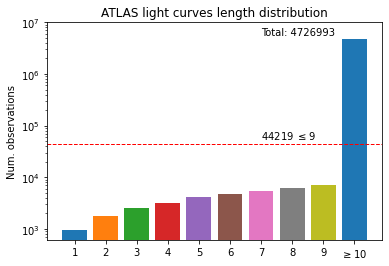

In [53]:
counter = 0
for i in range(1, 11):
    sub = meta[meta['N']<=i]
    plt.bar(i, sub.shape[0])
    counter += sub.shape[0]
    if i == 10:
        plt.bar(i, meta.shape[0])
        plt.text(i-3,meta.shape[0]+10e5, 'Total: {}'.format(meta.shape[0]))
        plt.text(i-3, counter+10e3, '{} $\leq 9$'.format(counter))
        plt.axhline(y=counter, color='r', linestyle='--', linewidth=1)
plt.yscale('log')
plt.ylim(0, 10e6)
plt.ylabel('Num. observations')
plt.title('ATLAS light curves length distribution')
plt.xticks(range(1, 11), list(range(1, 10))+[r'$\geq 10$'])
plt.show()

In [54]:
change_labels = {'LPV WoodA':'LPV',
                 'LPV WoodB':'LPV', 
                 'LPV WoodC':'LPV', 
                 'LPV WoodD':'LPV'}
meta['Class'] = meta['Class'].replace(change_labels)

In [63]:
meta['Class'].value_counts()

UNK    4726993
Name: Class, dtype: int64

0.3078769103317902

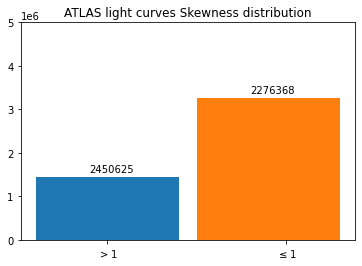

In [136]:
plt.bar(0, meta[meta['Skewness'].abs()>1].shape[0])
plt.text(-0.1, meta[meta['Skewness'].abs()>1].shape[0]+1e5, '{}'.format(meta[meta['Std']>0.1].shape[0]))
plt.bar(0.9, meta[meta['Skewness'].abs()<=1].shape[0])
plt.text(0.8, meta[meta['Skewness'].abs()<=1].shape[0]+1e5, '{}'.format(meta[meta['Std']<=0.1].shape[0]))
plt.ylim(0, 5e6)
plt.xticks([0, 1], ['$>1$', '$\leq 1$'])
plt.title('ATLAS light curves Skewness distribution')
meta[meta['Skewness'].abs()>=1].shape[0]/meta.shape[0]

In [141]:
meta_v2 = meta[meta['Std']>0.1]
meta_v2 = meta_v2[meta_v2['Skewness'].abs()>1]
meta_v2 = meta_v2[meta_v2['Kurtosis']>10]
meta_v2 = meta_v2[meta_v2['N']>20]

In [142]:
meta_v2.shape[0]/meta.shape[0], meta_v2.shape[0]

(0.04189788307281183, 198051)

### Lightcurve frame sample

In [7]:
lc_df = pd.read_csv(os.path.join(source,  
                                 meta['Path'].sample(1).values[0].split('/')[-1]), 
                    )
lc_df.head()

,mjd,mag,std
0,48823.6441,-9.481,0.005
1,48823.6537,-9.456,0.005
2,48823.6634,-9.466,0.006
3,48824.6249,-9.466,0.002
4,48824.6344,-9.460,0.002


### Creating training partitions from .csv to .record 

In [16]:
meta.shape

(21470, 5)

In [13]:
%%time

for fold_n in range(3): 
    test_meta  = pd.concat([frame.sample(n=100) for g, frame in meta.groupby('Class')])
    train_meta = meta[~meta['ID'].isin(test_meta['ID'])]
    print(test_meta.shape, train_meta.shape)
        
    for nsamples in [0]:  
        if nsamples == 0:
            partial_meta = train_meta
            target = './data/records/{}/fold_{}/{}'.format(name, fold_n, name)
        else:
            partial_meta = pd.concat([frame.sample(n=nsamples) for c, frame in train_meta.groupby('Class')])
            target = './data/records/{}/fold_{}/{}_{}'.format(name, fold_n, name, nsamples)

        create_dataset(partial_meta, source, target, max_lcs_per_record=20000, 
                       n_jobs=7, subsets_frac=(0.8, 0.2), test_subset=test_meta,  
                       names=['mjd', 'mag', 'errmag'],
                       delim_whitespace=True)

(1000, 5) (357288, 5)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:39<00:00, 39.94s/it]


(1000, 5) (357288, 5)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:37<00:00, 39.75s/it]


(1000, 5) (357288, 5)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:37<00:00, 39.78s/it]

CPU times: user 16min 54s, sys: 20.2 s, total: 17min 15s
Wall time: 19min 55s


### JUST ONE DATASET

In [17]:
name

'naul_macho'

In [19]:
for fold_n in range(3):
    target = './data/records/{}/fold_{}/{}'.format(name, fold_n, name)
    
    test_meta  = meta.sample(frac=0.2)
    train_meta = meta[~meta['ID'].isin(test_meta['ID'])]

    create_dataset(train_meta, source, target, max_lcs_per_record=20000, 
                   n_jobs=7, subsets_frac=(0.8, 0.2), 
                   test_subset=test_meta)

100%|████████████████████████████████████████████████████████████████████| 8/8 [01:02<00:00,  7.76s/it]


In [17]:
root = './data/records/new_ogle/'
for fold_n in range(3):
    fold_f = os.path.join(root, 'fold_{}'.format(fold_n))
    for source in os.listdir(fold_f):
        target = source.replace('new_', '')
        os.rename(os.path.join(fold_f, source), os.path.join(fold_f, target))